In [37]:
import faiss 
import numpy as np
import time 
import matplotlib.pyplot as plt 

In [4]:
BASE_DIR= '/Users/Damian/approximate-nearest-neighbor-graphs/Datasets/siftsmall'

<h2>Methods to read fvecs/ivecs Files</h2>

In [2]:
def read_fvecs(fname):
    data = np.fromfile(fname,dtype="int32")
    if data is None:
        raise ValueError("Not valida fvecs file")
    dim = data[0]
    assert data.shape%(dim+1) == 0, "Corrupted fvecs file"
    n = data.shape[0]//(dim+1)
    return data.reshape(n,dim+1)[:,1:].astype("float32")

def read_ivecs(fname):
    data = np.fromfile(fname,dtype='int32')
    if data is None:
        raise ValueError("Not valida ivecs file")
    dim = data[0]
    assert data.shape%(dim+1) == 0, "Corrupted ivecs file"
    n = data.shape[0]//(dim+1)
    return data.reshape(n,dim+1)[:,1:].astype("int32")

<h2>Reading and Implementing IndexFlatL2</h2>

In [5]:
#read data
xb = read_fvecs(f"{BASE_DIR}/siftsmall_base.fvecs")
xq = read_fvecs(f"{BASE_DIR}/siftsmall_query.fvecs")
gt = read_ivecs(f"{BASE_DIR}/siftsmall_groundtruth.ivecs")



In [9]:
def time_search(index, xq, k):
    start = time.time()
    D, I = index.search(xq, k)
    end = time.time()
    return D, I, end - start

In [10]:
#we will use IndexFlatL2 for exact search 
index = faiss.IndexFlatL2(xb.shape[1])
index.add(xb)
k =20
D,I,search_time = time_search(index, xq, k)
print(f"Exact search time for {xq.shape[0]} queries: {search_time:.4f} seconds")

Exact search time for 100 queries: 0.3267 seconds


In [12]:
for index, nn in enumerate(I[:5]):
    print(f"Query {index+1} nearest neighbors: {nn}")

Query 1 nearest neighbors: [  74 4181 2516 3613 4300 4152 2019 2553 4314 4060 9171 3780 3524 2808
 4353 1907 3295  463 1646  531]
Query 2 nearest neighbors: [ 839 1033 4060 4413 4314 4152 2553 9171 3524 3187 2075 2808 1907 9371
 3298 4429 3613 2607 1367  755]
Query 3 nearest neighbors: [2698 2256  879   12 5834  391  167 2593 2123 7059 9046 1837 4468 9895
 4266 9950 1817  415 2335  153]
Query 4 nearest neighbors: [2906 4269 4243 4062 2630 3061 2405  755  964  609 4270 1543 2734 1664
 3515 3336  462 7827 1292 3883]
Query 5 nearest neighbors: [3574 8630 3980 9365 4667 2623 4155 4547 2467  472 5834  827 4897  802
 1861 6506 1344 4259 3369 2980]


<h2>HNSW</h2>

In [14]:
index_hnsw = faiss.IndexHNSWFlat(xb.shape[1],16)
index_hnsw.efConstruction = 32
index_hnsw.add(xb)

<p>how many nodes does each layer has</p>

In [26]:
levels = faiss.vector_to_array(index_hnsw.hnsw.levels)
print(f"Total Layers (0-{int(levels.max())}): {int(levels.max())+1}")
for l in range(levels.max()+1):
    num_nodes = int((levels >= (l+1)).sum())
    print(f"Layer {l}: Number of nodes: {num_nodes}")

Total Layers (0-4): 5
Layer 0: Number of nodes: 10000
Layer 1: Number of nodes: 602
Layer 2: Number of nodes: 23
Layer 3: Number of nodes: 3
Layer 4: Number of nodes: 0


<p>calculating the queries using HNSW</p>

In [28]:
index_hnsw.hnsw.efSearch =48 
D_pred , I_pred, search_hnsw_time = time_search(index_hnsw, xq, k)
print(f"HNSW search time for {xq.shape[0]} queries: {search_hnsw_time:.4f} seconds")
for index, nn in enumerate(I_pred[:5]):
    print(f"Query {index+1} nearest neighbors (HNSW): {nn}")

HNSW search time for 100 queries: 0.0421 seconds
Query 1 nearest neighbors (HNSW): [  74 4181 2516 3613 4300 4152 2019 2553 4314 4060 9171 3780 3524 2808
 4353 1907 3295  463 1646  531]
Query 2 nearest neighbors (HNSW): [ 839 1033 4060 4413 4314 4152 2553 9171 3524 3187 2075 2808 1907 9371
 3298 4429 3613 2607 1367  755]
Query 3 nearest neighbors (HNSW): [2698 2256  879   12 5834  391  167 2593 2123 7059 1837 4468 9895 4266
 9950  415 2335  153 6347 5379]
Query 4 nearest neighbors (HNSW): [2906 4269 4243 4062 2630 3061 2405  755  964  609 4270 1543 2734 1664
 3515 3336  462 7827 1292 3883]
Query 5 nearest neighbors (HNSW): [3574 8630 3980 9365 4155 4547 2467  472  827 4897  802 1861 6506 1344
 4259 3369 2980  166 1128 8230]


<p>As we can see the time calculation of the queries using HNSW dropped dramatically</p>

<h2>Recall Calculation</h2>

In [29]:
def recall_at_k(I_true,I_pred,k):
    inter = 0
    for t,p in zip(I_true,I_pred):
        inter += len(set(t[:k]).intersection(p[:k]))
    return inter/(I_true.shape[0]*k)

In [30]:
recall = recall_at_k(I, I_pred, k)
print(f"Recall@{k} for HNSW: {recall:.4f}")

Recall@20 for HNSW: 0.9490


<p>As we can see the HNSW had approximately 95% based on the IndexFlatL2</p>

<h2>QPS calculation</h2>

In [31]:
def measure_qps(index,xq,k):
    start = time.time()
    D,I = index.search(xq,k)
    end = time.time()
    total_time = end-start
    qps = len(xq)/total_time
    return qps 

In [65]:
#TODO: Combine qps and recall 
def measure_qps_recall(index,xq,k,I_true=None,random_state=42):
    np.random.seed(random_state)
    start = time.time()
    D,I = index.search(xq,k)
    end = time.time()
    total_time = end-start
    qps = len(xq)/total_time
    if I_true is not None:
        recall = recall_at_k(I_true,I,k)
        return qps, recall
    return qps


In [35]:
print(f"Exact search QPS: {measure_qps(index_hnsw,xq,k):.2f} queries/second")

Exact search QPS: 1358.03 queries/second


In [58]:
def plot_qps_recall(results,title="QPS vs Recall",save_path=None):
    fig, ax = plt.subplots(figsize=(10,6))

    names = [r['name'] for r in results]
    qps = [r['qps'] for r in results]
    recall = [r['recall'] for r in results]

    #for a clean line plot
    sorted_indices = np.argsort(recall)
    recall = [recall[i] for i in sorted_indices]
    qps = [qps[i] for i in sorted_indices]
    names = [names[i] for i in sorted_indices]

    ax.plot(recall,qps, marker='o',linestyle ='--',alpha=0.7)
    for i, name in enumerate(names):
        ax.annotate(name, (recall[i], qps[i]), textcoords="offset points", xytext=(0,8), ha='center')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Queries per Second (QPS)")
    ax.set_title(title)
    ax.grid(True,alpha=0.4)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

In [62]:
index_flat = faiss.IndexFlatL2(xb.shape[1])
index_flat.add(xb)
D_true, I_true = index_flat.search(xq, k)

In [63]:
results = []

for ef in [16,32,48,64,128,256]:
    index_hnsw.hnsw.efSearch = ef 
    qps , recall = measure_qps_recall(index_hnsw,xq,k,I_true)
    results.append({
        "name": f"HNSW efSearch={ef}",
        "qps": qps,
        "recall": recall
    })



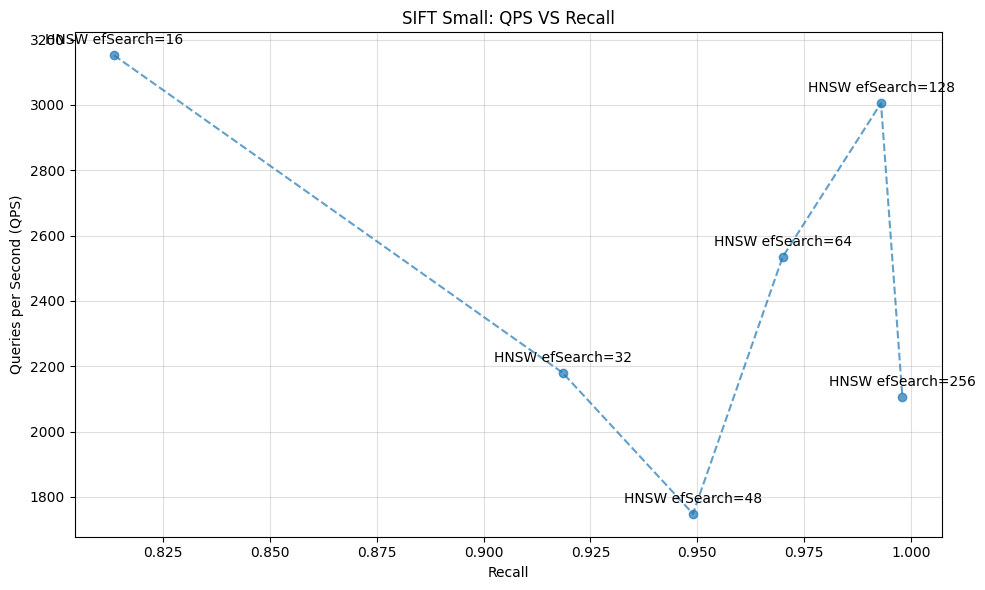

In [64]:
plot_qps_recall(results,title="SIFT Small: QPS VS Recall")
